In [1]:

import os
from sktime.benchmarking.forecasting import ForecastingBenchmark
from sktime.datasets import load_airline
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanSquaredPercentageError, MeanAbsolutePercentageError
from sktime.forecasting.compose import ColumnEnsembleForecaster

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from datetime import datetime

from sktime.split import SlidingWindowSplitter
from sktime.utils.plotting import plot_windows
from sktime.forecasting.base import ForecastingHorizon

from oceanwave_forecast import data_manager, data_pipeline, forecasting_utils

import os
import importlib
import joblib
importlib.reload(data_manager)
importlib.reload(data_pipeline)
importlib.reload(forecasting_utils)

from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import ARIMA, AutoARIMA

from sktime.forecasting.model_evaluation import evaluate

from sktime.transformations.series.detrend import Deseasonalizer, Detrender



from sktime.split import temporal_train_test_split
from sktime.transformations.compose import ColumnEnsembleTransformer
from sktime.forecasting.darts import DartsXGBModel 


from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    ForecastingRandomizedSearchCV,
)
from scipy.stats import randint, uniform        # for random search



In [2]:
# Define the paths
folder1_txt = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\data\\raw\\Standard meteorological data 2024\\46088h2024.txt'
output_dir = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\models\\benchmarks'
processed_data_dir = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\data\\processed'
pipeline_dir = 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\models\\pipelines'

data_ocean_raw = data_manager.extract_raw_data(folder1_txt)
data_ocean_raw.info()
processed_data = data_pipeline.preprocess_ocean_data(data_ocean_raw)
processed_data.info()

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_manager.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


DataFrame shape: (52650, 13)

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52650 entries, 2024-01-01 00:00:00 to 2024-12-31 23:50:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WDIR    52650 non-null  float64
 1   WSPD    52650 non-null  float64
 2   GST     52650 non-null  float64
 3   WVHT    52650 non-null  float64
 4   DPD     52650 non-null  float64
 5   APD     52650 non-null  float64
 6   MWD     52650 non-null  float64
 7   PRES    52650 non-null  float64
 8   ATMP    52650 non-null  float64
 9   WTMP    52650 non-null  float64
 10  DEWP    52650 non-null  float64
 11  VIS     52650 non-null  float64
 12  TIDE    52650 non-null  float64
dtypes: float64(13)
memory usage: 5.6 MB

Descriptive statistics:
               WDIR          WSPD           GST          WVHT           DPD  \
count  52650.000000  52650.000000  52650.000000  52650.000000  52650.000000   
mean     194.421026      4.962283      6.

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_pipeline.py:120: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_ocean_hourly = data_ocean_clean.resample('H').mean()


In [4]:


one_day = 24
one_week = one_day * 7
horizon_steps = one_day*3 # 3 days prediction horizon
training_window = one_week*3  # 3 weeks of training data
fh = ForecastingHorizon(list(range(1, horizon_steps + 1)), is_relative=True)



In [7]:
# Truncate processed_data for the first 2 months: January and February 2024
data_first2m = processed_data.loc['2024-01':'2024-02']

# Create truncated target and exogenous variable sets
y_first2m = data_first2m[['WVHT', 'APD']].copy()
X_first2m = data_first2m.drop(columns=['WVHT', 'APD'])

# Split the truncated data using the existing temporal_train_test_split parameters
y_train, y_test, X_train, X_test = temporal_train_test_split(
    y=y_first2m,
    X=X_first2m,
    test_size=horizon_steps
)

print("Training and test sets created for the first two months.")

Training and test sets created for the first two months.


In [8]:

pipe_X, pipe_Y = data_pipeline.get_pipelines(list(X_train.columns))

X_train_transformed = pipe_X.fit_transform(X_train)
X_test_transformed  = pipe_X.transform(X_test)
Y_train_transformed = pipe_Y.fit_transform(y_train)
Y_test_transformed  = pipe_Y.transform(y_test)


c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model ca

pandas.core.frame.DataFrame

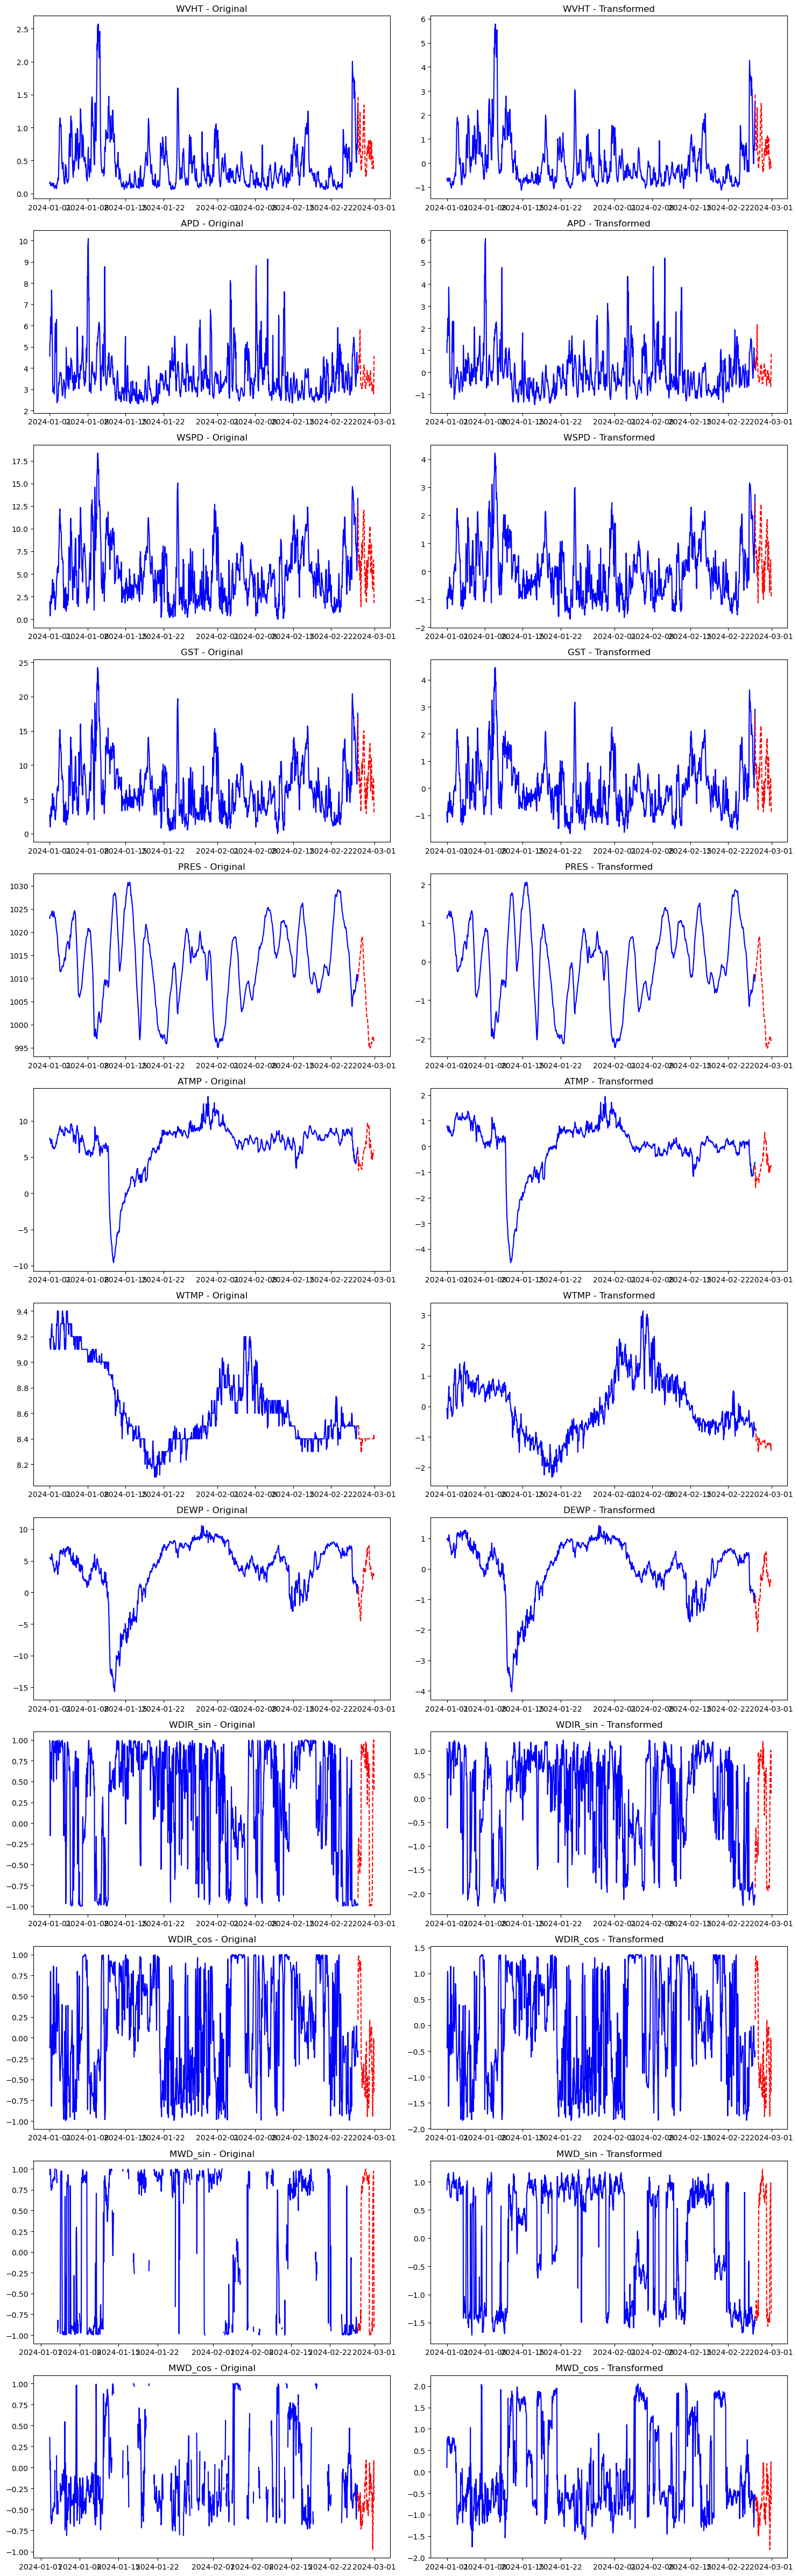

In [17]:
fig, axes = plt.subplots(len(X_first2m.columns) + len(y_first2m.columns), 2, figsize=(15, 4*(len(X_first2m.columns) + len(y_first2m.columns))))

# Target variables
for i, col in enumerate(y_first2m.columns):
    # Original data
    axes[i, 0].plot(y_train.index, y_train[col], color='blue')
    axes[i, 0].plot(y_test.index, y_test[col], color='red', linestyle='--')
    axes[i, 0].set_title(f"{col} - Original")
    
    # Transformed data
    if isinstance(Y_train_transformed, pd.DataFrame):
        axes[i, 1].plot(y_train.index, Y_train_transformed[col], color='blue')
        axes[i, 1].plot(y_test.index, Y_test_transformed[col], color='red', linestyle='--')
    else:
        axes[i, 1].plot(y_train.index, Y_train_transformed[:, i], color='blue')
        axes[i, 1].plot(y_test.index, Y_test_transformed[:, i], color='red', linestyle='--')
    axes[i, 1].set_title(f"{col} - Transformed")

# Exogenous variables
for i, col in enumerate(X_first2m.columns):
    idx = i + len(y_first2m.columns)
    
    # Original data
    axes[idx, 0].plot(X_train.index, X_train[col], color='blue')
    axes[idx, 0].plot(X_test.index, X_test[col], color='red', linestyle='--')
    axes[idx, 0].set_title(f"{col} - Original")
    
    # Transformed data
    if isinstance(X_train_transformed, pd.DataFrame):
        axes[idx, 1].plot(X_train.index, X_train_transformed[col], color='blue')
        axes[idx, 1].plot(X_test.index, X_test_transformed[col], color='red', linestyle='--')
    else:
        axes[idx, 1].plot(X_train.index, X_train_transformed[:, i], color='blue')
        axes[idx, 1].plot(X_test.index, X_test_transformed[:, i], color='red', linestyle='--')
    axes[idx, 1].set_title(f"{col} - Transformed")

plt.tight_layout()
plt.show()

# XGBOOST

In [73]:

lags_Y  = [-1,-2,-3,-24,-48]       # target history
lags_X  = [-1,-2,-3,-24,-48]           # exogenous history (all columns in X)

# Horizon (max step the CV splitter ever asks for)
encoders = {
    "datetime_attribute": {
        "past":   ["hour", "month"],
        "future": ["hour", "month"],
    }
}



In [ ]:
import xgboost as xgb

# exponential decay: every 10 boosting rounds multiply LR by 0.95
def lr_schedule(current_iter: int) -> float:
    base_lr = 0.1
    return base_lr * np.power(0.95, current_iter)

lr_scheduler = xgb.callback.LearningRateScheduler(lr_schedule)

In [ ]:
xgb_kwargs = dict(
    n_estimators        = 1000,
    learning_rate       = 0.3,
    max_depth           = 10,
    subsample           = 0.8,
    colsample_bytree    = 0.8,
    objective           = "reg:absoluteerror", # squarederror
    n_jobs              = -1,
    reg_alpha          = 0.1,
    callbacks          = [lr_scheduler]
)

forecaster_model = DartsXGBModel(
    lags                 = lags_Y,
    lags_past_covariates = lags_X,
    output_chunk_length  = len(fh),
    add_encoders         = encoders,
    random_state         = 42,
    multi_models         = False,
    kwargs               = xgb_kwargs,                   # → XGBRegressor(**xgb_kwargs)
)


forecaster_model.fit(
    y               = Y_train_transformed,
    X               = X_train_transformed,  
    fh              = fh
)

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


DartsXGBModel(add_encoders={'datetime_attribute': {'future': ['hour', 'month'],
                                                   'past': ['hour', 'month']}},
              kwargs={'callbacks': [<xgboost.callback.LearningRateScheduler object at 0x000001FCFFE147F0>],
                      'colsample_bytree': 0.8, 'learning_rate': 0.3,
                      'max_depth': 10, 'n_estimators': 1000, 'n_jobs': -1,
                      'objective': 'reg:absoluteerror', 'reg_alpha': 0.1,
                      'subsample': 0.8},
              lags=[-1, -2, -3, -24, -48],
              lags_past_covariates=[-1, -2, -3, -24, -48], multi_models=False,
              output_chunk_length=72, random_state=42)

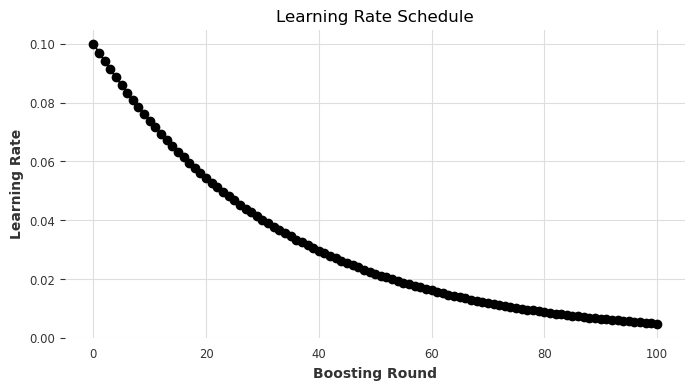

In [141]:
rounds = list(range(0, 101))
lrs = [lr_schedule(r) for r in rounds]

plt.figure(figsize=(8, 4))
plt.plot(rounds, lrs, marker='o')
plt.xlabel("Boosting Round")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.show()

Root Mean Squared Percentage Error: 0.3412


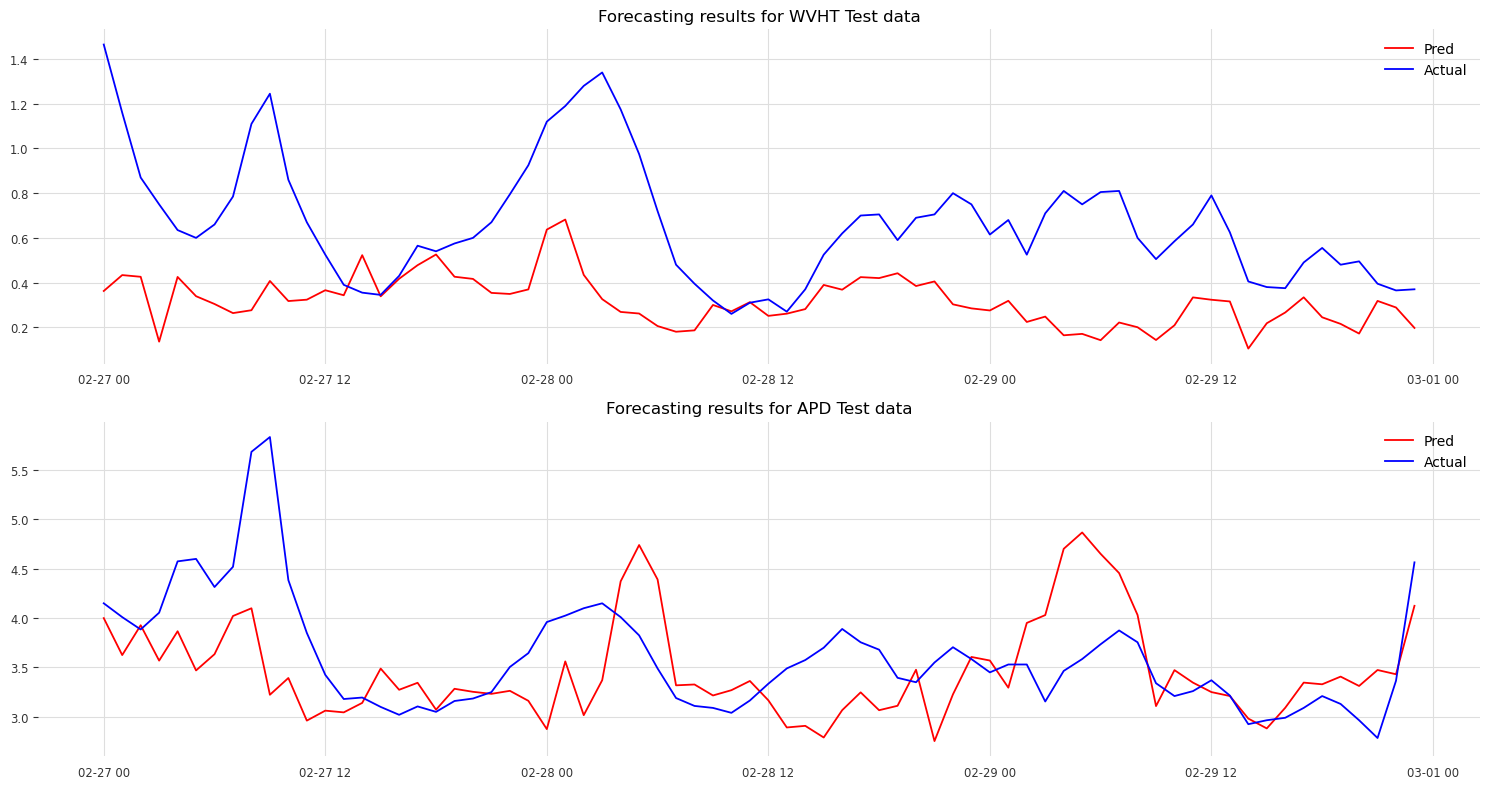

In [140]:



# 3. Make predictions for test period
y_pred = forecaster_model.predict(fh=fh, X=X_test_transformed)
y_pred = pipe_Y.inverse_transform(y_pred)

# 5. Calculate MSPE
mspe = MeanSquaredPercentageError(square_root=True)
error = mspe(y_test, y_pred)
print(f"Root Mean Squared Percentage Error: {error:.4f}")

# 6. Plot comparison
fig, axes = plt.subplots(len(y_test.columns), 1, figsize=(15, 4*len(y_test.columns)))

# Handle single column case
if len(y_test.columns) == 1:
    axes = [axes]

for i, col in enumerate(y_test.columns):
    axes[i].plot(y_pred.index, y_pred[col], color='red', label='Pred')
    axes[i].plot(y_test.index, y_test[col], color='blue', label='Actual')
    axes[i].set_title(f"Forecasting results for {col} Test data")
    axes[i].legend()

plt.tight_layout()
plt.show()

# HYPERPARAMETER TUNING

In [ ]:
from itertools import product

grid_kwargs = [
    {
        "n_estimators": n,
        "learning_rate": lr,
        "max_depth": d,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "objective": "reg:squarederror",
        "n_jobs": -1,
    }
    for n, lr, d in product(
        [1000, 400, 800],        # n_estimators
        [0.03, 0.05, 0.1],      # learning_rate
        [4, 6, 8],              # max_depth
    )
]

param_grid = {"kwargs": grid_kwargs}

searcher = ForecastingGridSearchCV(
    forecaster   = forecaster,          # your existing instance
    param_grid   = param_grid,
    cv           = cv,
    scoring      = MeanSquaredPercentageError(),
    n_jobs       = -1,
    verbose      = 1,
)

searcher.fit(y=Y_train_transformed, X=X_train_transformed)
print("Best XGB kwargs:", searcher.best_params_["kwargs"])
best_model = searcher.best_forecaster_

Fitting 48 folds for each of 27 candidates, totalling 1296 fits


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


Best XGB kwargs: {'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 6, 'subsample': 0.8, 'colsample_bytree': 0.8, 'objective': 'reg:squarederror', 'n_jobs': -1}
